In [1]:
# default_exp transformer

In [2]:
# all_func


# Transformer Embeddings

> Functions to train and evaluate ML models on embeddings from a pretrained Transformer.

In [3]:
# export

from peptide.imports import *
from peptide.basics import *
from peptide.utils import *
from peptide.learn import Learner
from peptide.data import (
    ACPDataset,
    AMPDataset,
    DNABindDataset,
)

## Load Data

In [4]:
acp_data = ACPDataset(DATA_STORE)
amp_data = AMPDataset(DATA_STORE)
dna_data = DNABindDataset(DATA_STORE, max_seq_len=300)

ESM has a max sequence length limitation of 1024.

In [5]:
dna_data.generate_fasta_files(use_seq_max_len=True)

Created /home/vinod/.peptide/datasets/dna/fasta/dna_train_seqlen_1024.fasta with 14189 sequence records
Created /home/vinod/.peptide/datasets/dna/fasta/dna_test_seqlen_1024.fasta with 2272 sequence records


## ESM

Details of the pretrained model:

Protein Sequence Embeddings (ProSE)
- Multi-task and masked language model-based protein sequence embedding models.
- https://github.com/tbepler/prose

### Create embeddings (in bulk) from fasta

**ACP**
- Train
```sh
python scripts/extract.py esm1b_t33_650M_UR50S ~/.peptide/datasets/acp/fasta/acp_train.fasta  ~/.peptide/datasets/acp/transformer/train/ \
    --repr_layers 0 32 33 --include mean
Transferred model to GPU
Read /home/vinod/.peptide/datasets/acp/fasta/acp_train.fasta with 1378 sequences
Processing 1 of 10 batches (292 sequences)
Processing 2 of 10 batches (215 sequences)
Processing 3 of 10 batches (178 sequences)
Processing 4 of 10 batches (157 sequences)
Processing 5 of 10 batches (132 sequences)
Processing 6 of 10 batches (117 sequences)
Processing 7 of 10 batches (105 sequences)
Processing 8 of 10 batches (91 sequences)
Processing 9 of 10 batches (80 sequences)
Processing 10 of 10 batches (11 sequences)
```
- Test
```sh
python scripts/extract.py esm1b_t33_650M_UR50S ~/.peptide/datasets/acp/fasta/acp_test.fasta  ~/.peptide/datasets/acp/transformer/test/ \
    --repr_layers 0 32 33 --include mean
Transferred model to GPU
Read /home/vinod/.peptide/datasets/acp/fasta/acp_test.fasta with 344 sequences
Processing 1 of 3 batches (175 sequences)
Processing 2 of 3 batches (113 sequences)
Processing 3 of 3 batches (56 sequences)
```

**AMP**
- Train
```sh
python scripts/extract.py esm1b_t33_650M_UR50S ~/.peptide/datasets/amp/fasta/amp_train.fasta  ~/.peptide/datasets/amp/transformer/train/ \
    --repr_layers 0 32 33 --include mean
Transferred model to GPU
Read /home/vinod/.peptide/datasets/amp/fasta/amp_train.fasta with 3234 sequences
Processing 1 of 30 batches (273 sequences)
Processing 2 of 30 batches (240 sequences)
...
Processing 29 of 30 batches (24 sequences)
Processing 30 of 30 batches (1 sequences)
```
- Test
```sh
python scripts/extract.py esm1b_t33_650M_UR50S ~/.peptide/datasets/amp/fasta/amp_test.fasta  ~/.peptide/datasets/amp/transformer/test/ \
    --repr_layers 0 32 33 --include mean
Transferred model to GPU
Read /home/vinod/.peptide/datasets/amp/fasta/amp_test.fasta with 808 sequences
Processing 1 of 9 batches (204 sequences)
Processing 2 of 9 batches (157 sequences)
...
Processing 9 of 9 batches (3 sequences)
```

**DNA Binding**
- Train
```sh
python scripts/extract.py esm1b_t33_650M_UR50S ~/.peptide/datasets/dna/fasta/dna_train_seqlen_1024.fasta  ~/.peptide/datasets/dna/transformer/train/ \
    --repr_layers 0 32 33 --include mean
Transferred model to GPU
Read /home/vinod/.peptide/datasets/dna/fasta/dna_train_seqlen_1024.fasta with 14189 sequences
Processing 1 of 1525 batches (67 sequences)
Processing 2 of 1525 batches (64 sequences)
```
- Whereas the following results in a max seq length error
```sh
python scripts/extract.py esm1b_t33_650M_UR50S ~/.peptide/datasets/dna/fasta/dna_train.fasta  ~/.peptide/datasets/dna/transformer/train/ \
    --repr_layers 0 32 33 --include mean
Transferred model to GPU
Read /home/vinod/.peptide/datasets/dna/fasta/dna_train.fasta with 14189 sequences
Processing 1 of 1641 batches (67 sequences)
...

```
- Test
```sh
python scripts/extract.py esm1b_t33_650M_UR50S ~/.peptide/datasets/dna/fasta/dna_test.fasta  ~/.peptide/datasets/dna/transformer/test/ \
    --repr_layers 0 32 33 --include mean
Transferred model to GPU
Read /home/vinod/.peptide/datasets/dna/fasta/dna_test.fasta with 2272 sequences
Processing 1 of 289 batches (56 sequences)
...

```

### Get embeddings
- From ESM Example - https://github.com/facebookresearch/esm/blob/main/examples/sup_variant_prediction.ipynb

In [6]:
def get_embeddings(fasta_path, emb_path, emb_layer):
    ys = []
    Xs = []
    for header, _seq in esm.data.read_fasta(fasta_path):
        label = header.split('|')[-1]
        ys.append(int(label))
        emb_file = f'{emb_path}/{header[1:]}.pt'
        embs = torch.load(emb_file)
        Xs.append(embs['mean_representations'][emb_layer])
    Xs = np.stack(Xs, axis=0)
    ys = np.stack(ys, axis=0)
    return Xs, ys

## Anti Cancer Peptide Dataset (ACP)

### ACP - Dimensionality Reduction (PCA) vs Full Data

In [7]:
X_train, y_train, X_test, y_test = acp_data.get_transformer_emb('acp_train.fasta', 'acp_test.fasta')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1378, 1280), (1378,), (344, 1280), (344,))

In [8]:
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
print(f'X_train_pca.shape: {X_train_pca.shape}')
print(
    f"Explained variance ratio of the first 10 principal components:\n{pca.explained_variance_ratio_[:10]}"
)

X_train_pca.shape: (1378, 50)
Explained variance ratio of the first 10 principal components:
[0.29824919 0.14635672 0.12145294 0.04919982 0.03232027 0.02831618
 0.02327273 0.01859285 0.01663856 0.01532567]


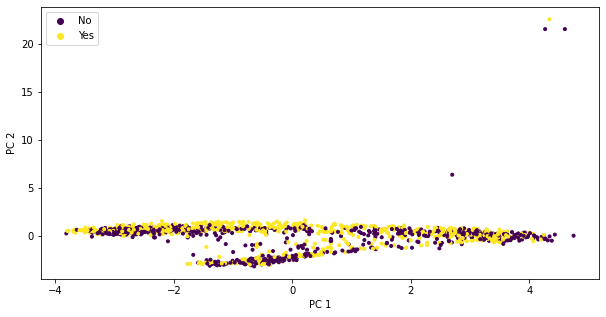

In [9]:
visualize_2pcs(X_train_pca, y_train)

Looks like scaling is needed

In [10]:
scaler = StandardScaler()
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(scaler.fit_transform(X_train))
print(f'X_train_pca.shape: {X_train_pca.shape}')
print(
    f"Explained variance ratio of the first 10 principal components:\n{pca.explained_variance_ratio_[:10]}"
)

X_train_pca.shape: (1378, 50)
Explained variance ratio of the first 10 principal components:
[0.21964596 0.1454748  0.0608479  0.04262361 0.03878565 0.03216271
 0.02793842 0.02416832 0.02228706 0.02031212]


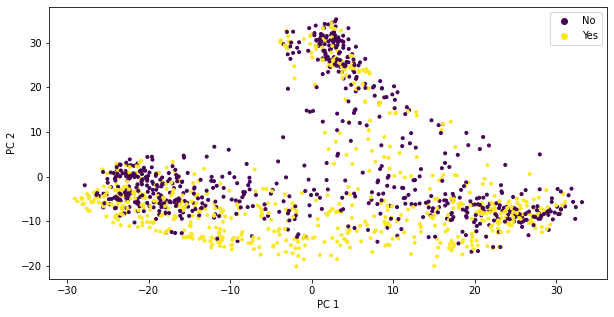

In [11]:
visualize_2pcs(X_train_pca, y_train)

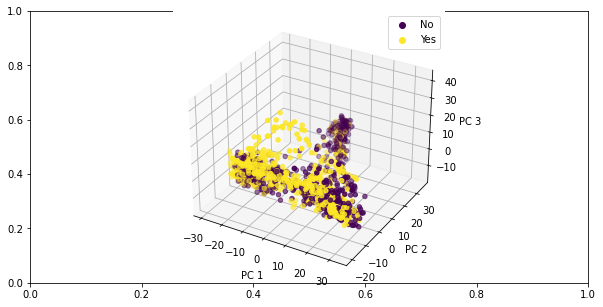

In [12]:
visualize_3pcs(X_train_pca, y_train)

Evaluation on full data

In [ ]:
train_predict(X_train, y_train, X_test, y_test)

,acc,recall,precision,f1
lr,0.726744,0.75,0.716667,0.732955
svc,0.729651,0.75,0.720670,0.735043
xgb,0.729651,0.75,0.720670,0.735043


Evaluation on reduced data

In [13]:
X_test_pca = pca.transform(scaler.transform(X_test))
train_predict(X_train_pca, y_train, X_test_pca, y_test)

/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,acc,recall,precision,f1
lr,0.651163,0.674419,0.644444,0.659091
svc,0.654070,0.674419,0.648045,0.660969
xgb,0.726744,0.755814,0.714286,0.734463


### ACP - Get Data and Learners (Layer 33 vs Layer 32)

Layer 33 is the final layer in the ESM model. Here we read data (embeddings) from layer 33 and 32 and initialize learners to run training and prediction on both. 
- Get data using the `ACPDataset` object
- Initialize / instantiate a `Learner` object using 

In [11]:
# layer 33
X_train, y_train, X_test, y_test = acp_data.get_transformer_emb('acp_train.fasta', 'acp_test.fasta')
acp_lyr33_learner = Learner(X_train, y_train, X_test, y_test, scaler=True) 
# layer 32
X_train, y_train, X_test, y_test = acp_data.get_transformer_emb('acp_train.fasta', 'acp_test.fasta', emb_layer=32)
acp_lyr32_learner = Learner(X_train, y_train, X_test, y_test, scaler=True) 

### ACP - Grid Search (Supervised Learning)

In [12]:
acp_lyr33_learner.pipeline.steps

[('scaler', StandardScaler()),
 ('pca', PCA(n_components=50)),
 ('classifier', 'passthrough')]

In [ ]:
#hide_output

_, _ = acp_lyr33_learner.train()

Starting grid search for LogisticRegression
Fitting 3 folds for each of 45 candidates, totalling 135 fits
Starting grid search for LinearSVC
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/p

Starting grid search for XGBClassifier
Fitting 3 folds for each of 32 candidates, totalling 96 fits


In [13]:
acp_lyr32_learner.pipeline.steps

[('scaler', StandardScaler()),
 ('pca', PCA(n_components=50)),
 ('classifier', 'passthrough')]

In [ ]:
#hide_output

_, _ = acp_lyr32_learner.train()

Starting grid search for LogisticRegression
Fitting 3 folds for each of 45 candidates, totalling 135 fits
Starting grid search for LinearSVC
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/p

Starting grid search for XGBClassifier
Fitting 3 folds for each of 32 candidates, totalling 96 fits


#### ACP - Grid Search Results
Comparing prediction performance between `layer 33` (final) and `layer 32` embeddings

In [ ]:
acp_lyr33_learner.predict()

,classifier,best_params,accuracy,recall,precision,f1
0,LogisticRegression,"{'classifier': LogisticRegression(C=10.0, max_...",0.642442,0.651163,0.640000,0.645533
1,LinearSVC,"{'classifier': LinearSVC(C=0.01, loss='hinge',...",0.680233,0.703488,0.672222,0.687500
2,XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.697674,0.738372,0.682796,0.709497


In [ ]:
acp_lyr32_learner.predict()

,classifier,best_params,accuracy,recall,precision,f1
0,LogisticRegression,"{'classifier': LogisticRegression(C=0.01, max_...",0.651163,0.656977,0.649425,0.653179
1,LinearSVC,"{'classifier': LinearSVC(loss='hinge', max_ite...",0.651163,0.651163,0.651163,0.651163
2,XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.709302,0.738372,0.697802,0.717514


### ACP - Label Spreading (Semi Supervised Learning)

In [15]:
acp_lyr33_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.75      0.63      0.69       172
           1       0.68      0.78      0.73       172

    accuracy                           0.71       344
   macro avg       0.71      0.71      0.71       344
weighted avg       0.71      0.71      0.71       344



In [16]:
acp_lyr32_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.73      0.69      0.71       172
           1       0.70      0.74      0.72       172

    accuracy                           0.72       344
   macro avg       0.72      0.72      0.71       344
weighted avg       0.72      0.72      0.71       344



### ACP - KMeans Clustering (Unsupervised Learning)

n_clusters: 2 -- avg silhouette score: 0.20614266395568848
n_clusters: 3 -- avg silhouette score: 0.2678752541542053
n_clusters: 4 -- avg silhouette score: 0.22976993024349213
n_clusters: 5 -- avg silhouette score: 0.21816931664943695
n_clusters: 6 -- avg silhouette score: 0.19376227259635925
n_clusters: 7 -- avg silhouette score: 0.19275081157684326
n_clusters: 8 -- avg silhouette score: 0.15833736956119537
n_clusters: 9 -- avg silhouette score: 0.146097332239151
n_clusters: 10 -- avg silhouette score: 0.1495611071586609


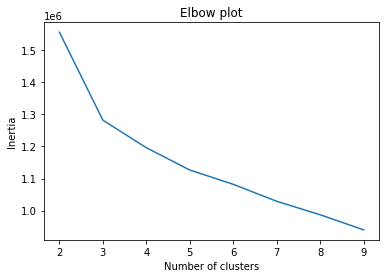

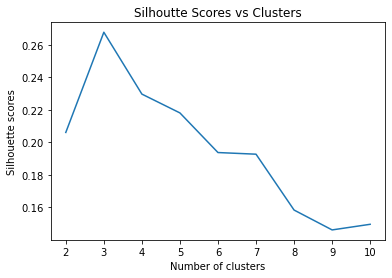

In [17]:
X_pca = acp_lyr33_learner.pick_k()

Cluster counts: Counter({0: 607, 3: 399, 1: 372, 2: 344})


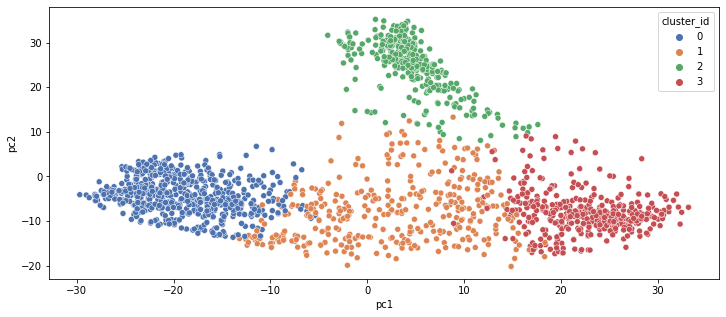

In [18]:
acp_lyr33_learner.analyze_clusters(X_pca, k=4)

## Antimicrobial Peptide Dataset (AMP)

### AMP - PCA vs Full Data

In [13]:
X_train, y_train, X_test, y_test = amp_data.get_transformer_emb('amp_train.fasta', 'amp_test.fasta')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3234, 1280), (3234,), (808, 1280), (808,))

In [15]:
scaler = StandardScaler()
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(scaler.fit_transform(X_train))
print(f'X_train_pca.shape: {X_train_pca.shape}')
print(
    f"Explained variance ratio of the first 10 principal components:\n{pca.explained_variance_ratio_[:10]}"
)

X_train_pca.shape: (3234, 50)
Explained variance ratio of the first 10 principal components:
[0.1967617  0.0848959  0.06348861 0.03493933 0.03121491 0.02762622
 0.02619583 0.02370695 0.0198074  0.01853634]


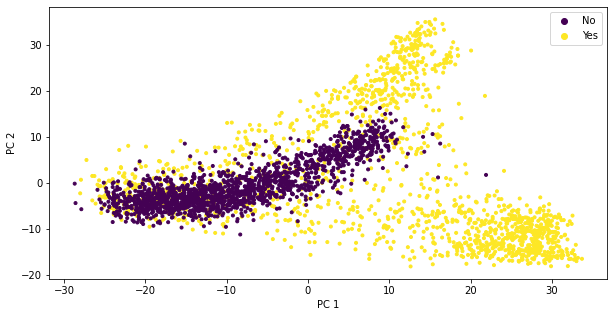

In [16]:
visualize_2pcs(X_train_pca, y_train)

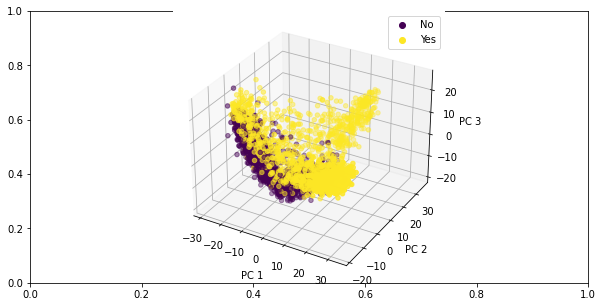

In [17]:
visualize_3pcs(X_train_pca, y_train)

Evaluation on full data

In [18]:
train_predict(X_train, y_train, X_test, y_test)

,acc,recall,precision,f1
lr,0.935644,0.909320,0.957560,0.932817
svc,0.936881,0.926952,0.943590,0.935197
xgb,0.938119,0.916877,0.955381,0.935733


Evaluation on reduced data

In [19]:
X_test_pca = pca.transform(scaler.transform(X_test))
train_predict(X_train_pca, y_train, X_test_pca, y_test)

/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,acc,recall,precision,f1
lr,0.935644,0.911839,0.955145,0.932990
svc,0.931931,0.901763,0.957219,0.928664
xgb,0.939356,0.901763,0.972826,0.935948


### AMP - Get Data and Learners (Layer 33 vs Layer 32)

In [21]:
# layer 33 (default)
X_train, y_train, X_test, y_test = amp_data.get_transformer_emb('amp_train.fasta', 'amp_test.fasta')
amp_lyr33_learner = Learner(X_train, y_train, X_test, y_test, scaler=True) 

# layer 32
X_train, y_train, X_test, y_test = amp_data.get_transformer_emb('amp_train.fasta', 'amp_test.fasta', emb_layer=32)
amp_lyr32_learner = Learner(X_train, y_train, X_test, y_test, scaler=True) 

### AMP - Grid Search (Supervised Learning)

In [22]:
amp_lyr33_learner.pipeline.steps

[('scaler', StandardScaler()),
 ('pca', PCA(n_components=50)),
 ('classifier', 'passthrough')]

In [ ]:
#hide_output

_, _ = amp_lyr33_learner.train()

Starting grid search for LogisticRegression
Fitting 3 folds for each of 45 candidates, totalling 135 fits
Starting grid search for LinearSVC
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/p

Starting grid search for XGBClassifier
Fitting 3 folds for each of 32 candidates, totalling 96 fits


In [23]:
amp_lyr32_learner.pipeline.steps

[('scaler', StandardScaler()),
 ('pca', PCA(n_components=50)),
 ('classifier', 'passthrough')]

In [ ]:
#hide_output

_, _ = amp_lyr32_learner.train()

Starting grid search for LogisticRegression
Fitting 3 folds for each of 45 candidates, totalling 135 fits
Starting grid search for LinearSVC
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/p

Starting grid search for XGBClassifier
Fitting 3 folds for each of 32 candidates, totalling 96 fits


#### AMP - Grid Search Results
Comparing prediction performance between `layer 33` (final) and `layer 32` embeddings

In [ ]:
amp_lyr33_learner.predict()

,classifier,best_params,accuracy,recall,precision,f1
0,LogisticRegression,"{'classifier': LogisticRegression(C=0.01, max_...",0.931931,0.899244,0.959677,0.928479
1,LinearSVC,"{'classifier': LinearSVC(C=10.0, loss='hinge',...",0.931931,0.899244,0.959677,0.928479
2,XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.934406,0.891688,0.972527,0.930355


In [ ]:
amp_lyr32_learner.predict()

,classifier,best_params,accuracy,recall,precision,f1
0,LogisticRegression,"{'classifier': LogisticRegression(C=0.01, max_...",0.924505,0.881612,0.961538,0.919842
1,LinearSVC,"{'classifier': LinearSVC(C=100.0, max_iter=200...",0.918317,0.863980,0.966197,0.912234
2,XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.939356,0.914358,0.960317,0.936774


### AMP - Label Spreading (Semi Supervised Learning)

In [24]:
amp_lyr33_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       411
           1       0.97      0.88      0.92       397

    accuracy                           0.93       808
   macro avg       0.93      0.93      0.93       808
weighted avg       0.93      0.93      0.93       808



In [25]:
amp_lyr32_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       411
           1       0.96      0.88      0.92       397

    accuracy                           0.92       808
   macro avg       0.92      0.92      0.92       808
weighted avg       0.92      0.92      0.92       808



### AMP - KMeans Clustering (Unsupervised Learning)

n_clusters: 2 -- avg silhouette score: 0.19373548030853271
n_clusters: 3 -- avg silhouette score: 0.21837416291236877
n_clusters: 4 -- avg silhouette score: 0.187213733792305
n_clusters: 5 -- avg silhouette score: 0.1776735484600067
n_clusters: 6 -- avg silhouette score: 0.17970021069049835
n_clusters: 7 -- avg silhouette score: 0.1797829568386078
n_clusters: 8 -- avg silhouette score: 0.1493576169013977
n_clusters: 9 -- avg silhouette score: 0.12389330565929413
n_clusters: 10 -- avg silhouette score: 0.1260935217142105


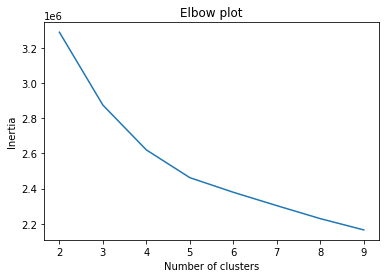

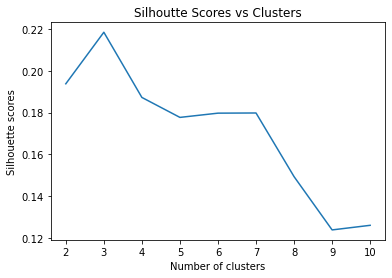

In [26]:
X_pca = amp_lyr33_learner.pick_k()

Cluster counts: Counter({0: 1284, 1: 872, 4: 820, 2: 586, 3: 367, 5: 113})


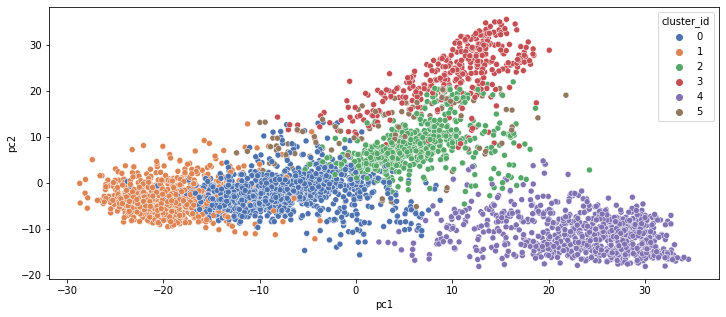

In [27]:
amp_lyr33_learner.analyze_clusters(X_pca, k=6)

## DNA Binding Dataset

### DNA - PCA vs Full Data

In [14]:
X_train, y_train, X_test, y_test = dna_data.get_transformer_emb('dna_train_seqlen_300.fasta', 'dna_test_seqlen_300.fasta')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14189, 1280), (14189,), (2272, 1280), (2272,))

In [15]:

pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
print(f'X_train_pca.shape: {X_train_pca.shape}')
print(
    f"Explained variance ratio of the first 10 principal components:\n{pca.explained_variance_ratio_[:10]}"
)

X_train_pca.shape: (14189, 50)
Explained variance ratio of the first 10 principal components:
[0.20549123 0.07429419 0.0339251  0.03367166 0.02754678 0.02543029
 0.02173495 0.01814981 0.01678294 0.01414294]


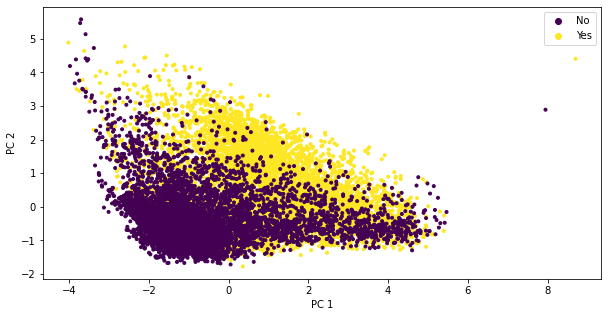

In [16]:
visualize_2pcs(X_train_pca, y_train)

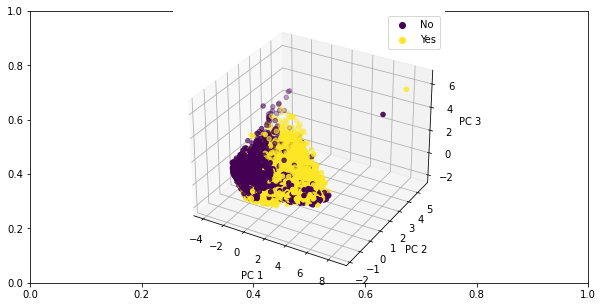

In [17]:
visualize_3pcs(X_train_pca, y_train)

Evaluation on full data

In [18]:
train_predict(X_train, y_train, X_test, y_test)

/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,acc,recall,precision,f1
lr,0.827465,0.897658,0.790680,0.840780
svc,0.827905,0.911535,0.784328,0.843161
xgb,0.843310,0.969644,0.776928,0.862654


Evaluation on reduced data

In [19]:
X_test_pca = pca.transform(X_test)
train_predict(X_train_pca, y_train, X_test_pca, y_test)

/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,acc,recall,precision,f1
lr,0.755282,0.843886,0.721275,0.777778
svc,0.754842,0.850824,0.718155,0.778881
xgb,0.818222,0.960104,0.751018,0.842786


### DNA - Get Data and Learners (Layer 33 vs Layer 32)

In [5]:
# layer 33 (default)
X_train, y_train, X_test, y_test = dna_data.get_transformer_emb('dna_train_seqlen_300.fasta', 'dna_test_seqlen_300.fasta')
dna_lyr33_learner = Learner(X_train, y_train, X_test, y_test, scaler=True) 

# layer 32
X_train, y_train, X_test, y_test = dna_data.get_transformer_emb('dna_train_seqlen_300.fasta', 'dna_test_seqlen_300.fasta', emb_layer=32)
dna_lyr32_learner = Learner(X_train, y_train, X_test, y_test, scaler=True) 

### DNA - Grid Search (Supervised Learning)

In [26]:
dna_lyr33_learner.pipeline.steps

[('scaler', StandardScaler()),
 ('pca', PCA(n_components=50)),
 ('classifier', 'passthrough')]

In [29]:
#hide_output

_, _ = dna_lyr33_learner.train()

Starting grid search for LogisticRegression
Fitting 3 folds for each of 45 candidates, totalling 135 fits
Starting grid search for LinearSVC
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/p

Starting grid search for XGBClassifier
Fitting 3 folds for each of 32 candidates, totalling 96 fits


In [27]:
dna_lyr32_learner.pipeline.steps

[('scaler', StandardScaler()),
 ('pca', PCA(n_components=50)),
 ('classifier', 'passthrough')]

In [30]:
#hide_output

_, _ = dna_lyr32_learner.train()

Starting grid search for LogisticRegression
Fitting 3 folds for each of 45 candidates, totalling 135 fits
Starting grid search for LinearSVC
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/p

Starting grid search for XGBClassifier
Fitting 3 folds for each of 32 candidates, totalling 96 fits


#### DNA - Grid Search Results
Comparing prediction performance between `layer 33` (final) and `layer 32` embeddings

In [31]:
dna_lyr33_learner.predict()

,classifier,best_params,accuracy,recall,precision,f1
0,LogisticRegression,"{'classifier': LogisticRegression(C=0.01, max_...",0.756162,0.842151,0.723008,0.778045
1,LinearSVC,"{'classifier': LinearSVC(C=0.01, max_iter=2000...",0.754401,0.846487,0.719234,0.777689
2,XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.830546,0.969644,0.761580,0.853110


In [32]:
dna_lyr32_learner.predict()

,classifier,best_params,accuracy,recall,precision,f1
0,LogisticRegression,"{'classifier': LogisticRegression(C=0.01, max_...",0.794894,0.847355,0.771113,0.807438
1,LinearSVC,"{'classifier': LinearSVC(C=10.0, loss='hinge',...",0.798856,0.858630,0.771028,0.812474
2,XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.848151,0.962706,0.786119,0.865497


### DNA - Label Spreading (Semi Supervised Learning)

In [33]:
dna_lyr33_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.87      0.61      0.71      1119
           1       0.70      0.91      0.79      1153

    accuracy                           0.76      2272
   macro avg       0.79      0.76      0.75      2272
weighted avg       0.79      0.76      0.75      2272



In [34]:
dna_lyr32_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.88      0.70      0.78      1119
           1       0.76      0.91      0.83      1153

    accuracy                           0.81      2272
   macro avg       0.82      0.81      0.80      2272
weighted avg       0.82      0.81      0.81      2272



### DNA - KMeans Clustering (Unsupervised Learning)

In [2]:
# X_pca = dna_lyr33_learner.pick_k()

In [1]:
# dna_lyr33_learner.analyze_clusters(X_pca, k=6)

## Export -

In [ ]:
# hide
from nbdev.export import *

notebook2script()


Converted 00_basics.ipynb.
Converted 01_data.ipynb.
Converted 02_onehot.ipynb.
Converted 03_lstm.ipynb.
Converted 04_transformer.ipynb.
Converted index.ipynb.
